# Project_1_Amazon Food Review

# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
cf.go_offline();
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')
warnings.warn('this will not show')

pd.set_option('display.max_columns', None)


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter
from numpy import where

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

from scipy.sparse import hstack, vstack

from prettytable import PrettyTable
from scipy.stats import loguniform # Log-uniform is useful for searching penalty values as we often explore values at different orders of magnitude, at least as a first step
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blues\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\blues\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df = pd.read_csv("Reviews.csv", delimiter=',', engine='python', encoding='utf-8', error_bad_lines=False)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.shape

(568454, 10)

In [6]:
# Limiting current dataset to 10000 rows
df = df[:10000]

# Understanding the Dataset:

In [7]:
print('No. of datapoints/rows: {}'.format(df.shape[0]))
print('No. of features/columns: {}'.format(df.shape[1]))

No. of datapoints/rows: 10000
No. of features/columns: 10


In [8]:
print("Feature names: \n{}".format(df.columns))

Feature names: 
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


# Exploratory Data Analysis (EDA_1)

In [9]:
#Check null and missing values
# Calculate the number of missing values in each column using isna()
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [10]:
# Calculate the number of missing values in each column
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


# Check the score distribution

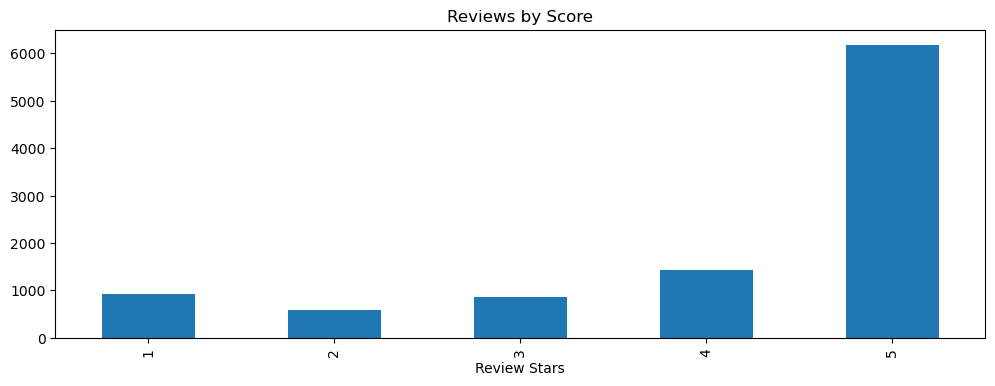

In [12]:
x = df['Score'].value_counts().sort_index().plot(kind='bar', title='Reviews by Score', figsize=(12, 4))
x.set_xlabel('Review Stars')
plt.show()

In [13]:
df['Score'].value_counts()

5    6183
4    1433
1     932
3     862
2     590
Name: Score, dtype: int64

# Check duplicate values

In [14]:
duplicates = df[df.duplicated(subset=['ProductId', 'UserId', 'ProfileName', 'Time', 'Text'], keep=False)]
duplicates

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
466,467,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0,0,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
2334,2335,B0001FQVCK,A5D06XJHDXK75,C. Po,3,3,5,1190592000,Chocolate Italian kisses - need I say more?,My family has been in love with Baci's ever si...
2336,2337,B0001FQVCK,A5D06XJHDXK75,C. Po,1,1,5,1190592000,"Baci's are pure heaven - great gift, stocking ...",My family has been in love with Baci's ever si...
2613,2614,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,4,4,4,1300579200,lots of uses for this green tea...,lots of uses for this green tea...<br /><br />...
2636,2637,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,3,4,2,1313107200,Way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2647,2648,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,0,0,2,1313107200,way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2653,2654,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,0,0,4,1300579200,quality lightly sweetened green tea powder,lots of uses for this green tea...<br /><br />...
2941,2942,B0002TJAZK,A3TVZM3ZIXG8YW,christopher hayes,7,11,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ..."
2943,2944,B0002TJAZK,A2ISKAWUPGGOLZ,M. S. Handley,2,4,1,1310774400,Kitty Junk Food,We have five cats - one an elderly cat of 15 y...


In [15]:
df.duplicated(subset=['ProductId', 'UserId', 'ProfileName', 'Time', 'Text'], keep=False).value_counts()

False    9978
True       22
dtype: int64

In [16]:
duplicates[duplicates['ProductId']=='B0016FY6H6']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2613,2614,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,4,4,4,1300579200,lots of uses for this green tea...,lots of uses for this green tea...<br /><br />...
2636,2637,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,3,4,2,1313107200,Way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2647,2648,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,0,0,2,1313107200,way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2653,2654,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,0,0,4,1300579200,quality lightly sweetened green tea powder,lots of uses for this green tea...<br /><br />...


# Data Cleaning

Drop duplicates

In [17]:
# Check original shape of the dataset
df.shape

(10000, 10)

In [18]:
# Drop the duplicates
df.drop_duplicates(subset=['ProductId', 'UserId', 'ProfileName', 'Time', 'Text'], keep='first', inplace=True)
df.shape

(9988, 10)

# Helpfulness numerator should not exceed Helpfulness denominator

In [19]:
df[df["HelpfulnessNumerator"] > df["HelpfulnessDenominator"]]
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [20]:
print(f"No. of Datapoints BEFORE discarding : {df.shape[0]}")

df = df[df["HelpfulnessNumerator"] <= df["HelpfulnessDenominator"]]

print(f"No. of Datapoints AFTER discarding : {df.shape[0]}")

No. of Datapoints BEFORE discarding : 9988
No. of Datapoints AFTER discarding : 9988


# Feature Engineering_1

In [21]:
print("Positive reviews:", df[df['Score']>3].shape[0])
print("Negative reviews:", df[df['Score']<=3].shape[0])

Positive reviews: 7612
Negative reviews: 2376


In [22]:
df['Review'] = [1 if x>3 else 0 for x in df['Score']] # set 1 for positive reviews, 0 for negative reviews
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [23]:
# Check negative and positive reviews (1, 2, 3 - negative; 4 and 5 - positive)
print("Negative values with scores 1, 2 and 3:", len(df[df['Review']==0]))
print("Positive values with score 4 and 5:", len(df[df['Review']==1]))

Negative values with scores 1, 2 and 3: 2376
Positive values with score 4 and 5: 7612


# Add Word Count feature

In [24]:
df['WordCount'] = df['Text'].apply(lambda x: len(x.split()))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27


# Add Character Count feature

In [25]:
df['CharacterCount'] = df['Text'].apply(lambda x: len(x))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140


# Add Helpfulness percentage feature

In [26]:
df["HelpfulnessPercentage"] = df[["HelpfulnessNumerator","HelpfulnessDenominator"]].apply(lambda x: ((x[0]/x[1])*100.0) if x[1] else 0.0, axis=1)
df.head(-5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount,HelpfulnessPercentage
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263,100.000000
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190,0.000000
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509,100.000000
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219,100.000000
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,9991,B000P41A28,A82CL6H9NWSJC,Carl Nothnagel,6,8,5,1302652800,"Baby loves, and so do we","Great product, our daughter loves this and has...",1,200,1038,75.000000
9991,9992,B000P41A28,A181WVPZSOKTVV,GRIZZLY,12,17,5,1312675200,Good product and highest quality - I'll elabor...,This is a good product and very high-quality. ...,1,284,1807,70.588235
9992,9993,B000P41A28,A3HINZRNCW1SKA,Happy Mom,1,1,5,1326240000,Awesome Similac Organic Formula,I was NEVER going to give my children formula....,1,160,935,100.000000
9993,9994,B000P41A28,AV3IMDC3C0F8,Miss K,1,1,5,1202256000,It's about time!,"As far as I can tell, this is the only organic...",1,39,210,100.000000


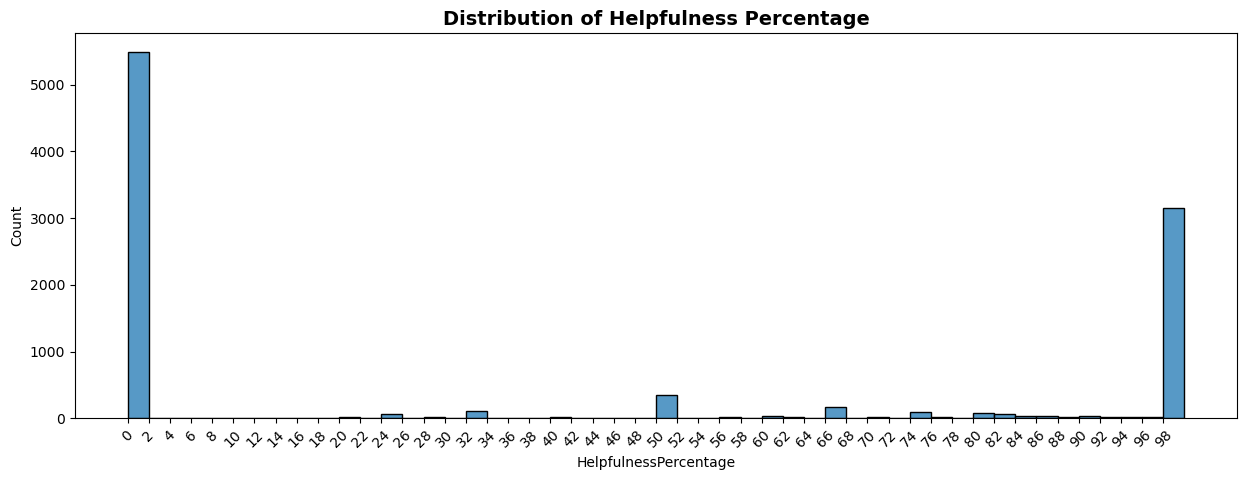

In [27]:
# Check the distribution of helpfulness percentage
plt.figure(figsize=(15,5))
sns.histplot(data=df["HelpfulnessPercentage"], bins=50)
plt.title("Distribution of Helpfulness Percentage",fontweight='bold', fontsize=14)
plt.xticks(range(0,100,2), rotation=45)
plt.show()

# Adding Helpfulness Indicator Feature

In [28]:
df.loc[df["HelpfulnessPercentage"] >= 75, 'HelpfulnessIndicator'] = 'Useful'
df.loc[(df["HelpfulnessPercentage"] > 40) & (df["HelpfulnessPercentage"] < 75), 'HelpfulnessIndicator'] = 'Intermediate'
df.loc[(df["HelpfulnessPercentage"] > 0) & (df["HelpfulnessPercentage"] <= 40), 'HelpfulnessIndicator'] = 'Not Useful'
df.loc[df["HelpfulnessPercentage"] == 0, 'HelpfulnessIndicator'] = 'Not Available'
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount,HelpfulnessPercentage,HelpfulnessIndicator
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263,100.0,Useful
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190,0.0,Not Available
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509,100.0,Useful
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219,100.0,Useful
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140,0.0,Not Available


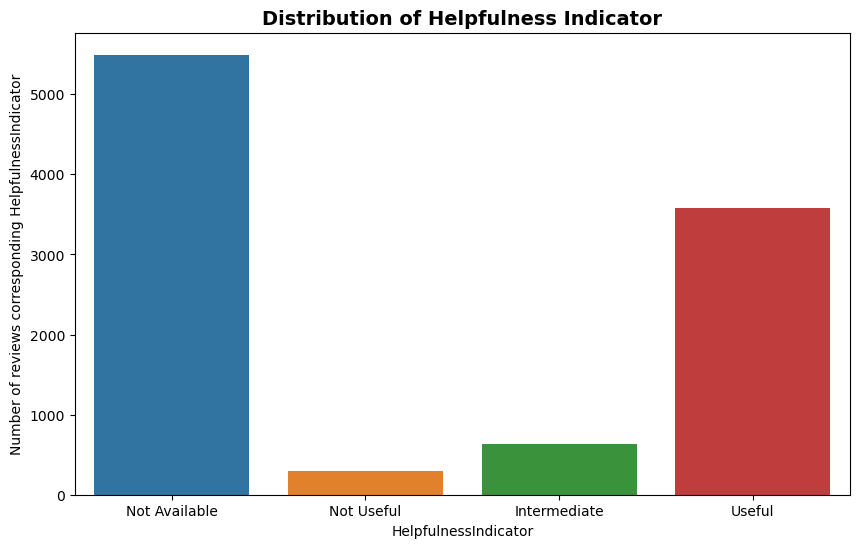


Not Available    5494
Not Useful        290
Intermediate      629
Useful           3575
Name: HelpfulnessIndicator, dtype: int64


In [29]:
plt.figure(figsize=(10,6))
sns.countplot(df, x='HelpfulnessIndicator', order=["Not Available","Not Useful","Intermediate","Useful"])
plt.title("Distribution of Helpfulness Indicator",fontweight='bold', fontsize=14)
plt.xlabel("HelpfulnessIndicator")
plt.ylabel("Number of reviews corresponding HelpfulnessIndicator")
plt.show()

print()

print(df['HelpfulnessIndicator'].value_counts()[[0,3,2,1]])

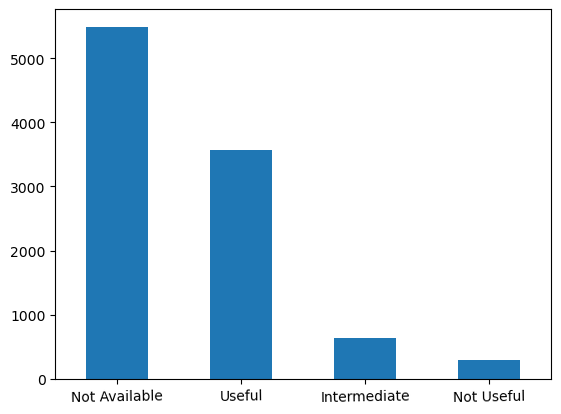


Count of Usefulness of Reviews:
Not Available    5494
Useful           3575
Intermediate      629
Not Useful        290
Name: HelpfulnessIndicator, dtype: int64


In [30]:
df.HelpfulnessIndicator.value_counts().plot(kind='bar', rot=1.0)
plt.show()
print("\nCount of Usefulness of Reviews:")
print(df.HelpfulnessIndicator.value_counts())

# Exploratory Data Analysis (EDA_2)

Distribution of useful and non-useful reviews in each of the set of Positive and Negative Reviews

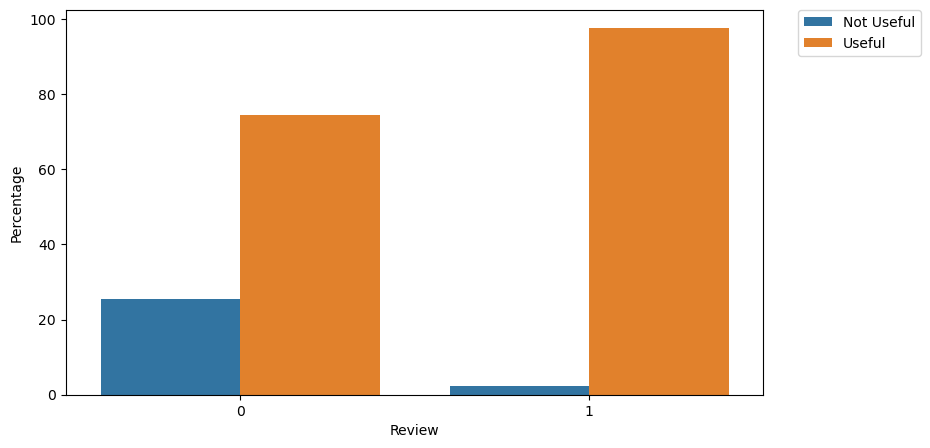

,Review,HelpfulnessIndicator,Percentage
0,0,Useful,74.440518
1,0,Not Useful,25.559482
2,1,Useful,97.579576
3,1,Not Useful,2.420424


In [31]:
df_temp = df[(df["HelpfulnessIndicator"]!= "Not Available") & (df["HelpfulnessIndicator"]!= "Intermediate")]
df_temp_1 = df_temp["HelpfulnessIndicator"].groupby(df_temp["Review"]).value_counts(normalize=True)
df_temp_1 = df_temp_1*100
df_temp_1 = df_temp_1.rename("Percentage").reset_index()

plt.figure(figsize=(9,5))
sns.barplot(data=df_temp_1, x="Review", y="Percentage", hue="HelpfulnessIndicator", hue_order=["Not Useful","Useful"]);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show()
print()
df_temp_1

# Usefulness vs Length of the Review

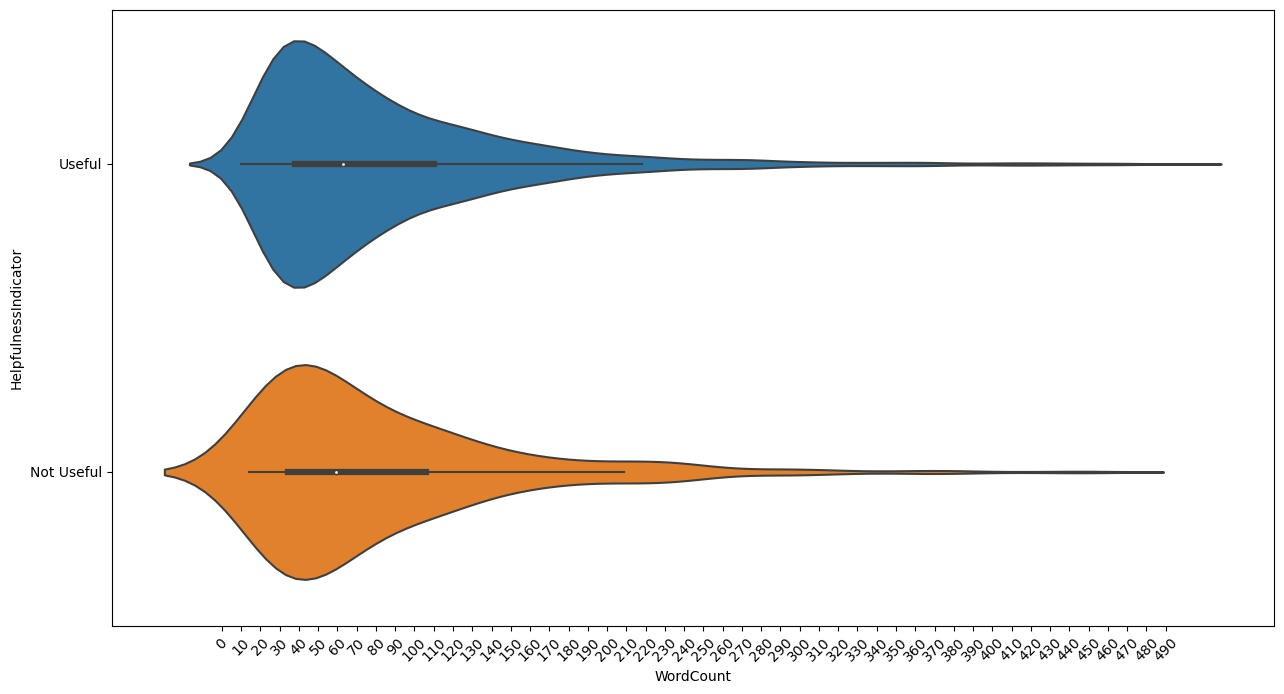

,count,mean,std,min,25%,50%,75%,max
HelpfulnessIndicator,,,,,,,,
Not Useful,287.0,81.975610,68.004238,14.0,34.5,59.0,106.0,445.0
Useful,3558.0,84.632659,68.806229,10.0,38.0,63.0,110.0,492.0


In [32]:
# Consider reviews with 500 words or less
temp_df_useful_nonuseful_500wc = df[(df["HelpfulnessIndicator"]!= "Not Available") & (df["HelpfulnessIndicator"]!= "Intermediate") & (df["WordCount"]<500)]
plt.figure(figsize=(15,8))
sns.violinplot(x='WordCount', y='HelpfulnessIndicator', data=temp_df_useful_nonuseful_500wc, orient="h")
plt.xticks(range(0,500,10), rotation=45)
plt.show()
print()

temp_df_useful_nonuseful_500wc["WordCount"].groupby(temp_df_useful_nonuseful_500wc["HelpfulnessIndicator"]).describe()

# Review Length vs Negative/Positive

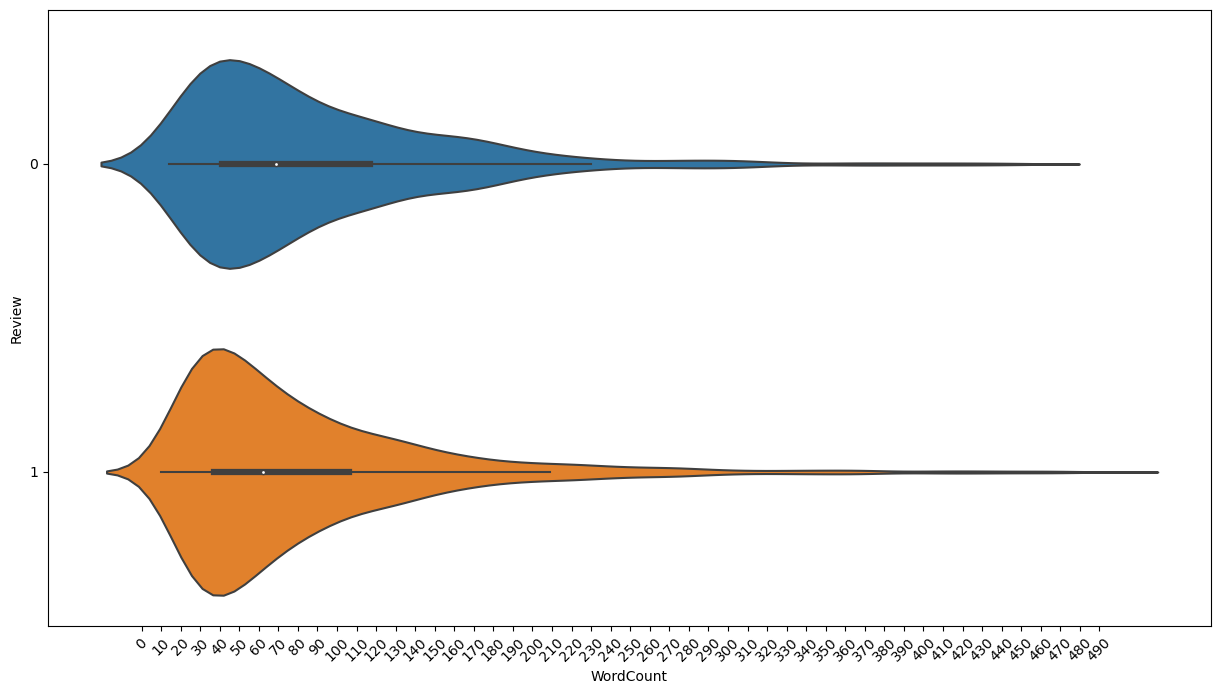

,count,mean,std,min,25%,50%,75%,max
Review,,,,,,,,
0,843.0,88.946619,66.856483,14.0,41.0,69.0,117.0,445.0
1,3002.0,83.167222,69.219604,10.0,37.0,62.0,106.0,492.0


In [33]:
plt.figure(figsize=(15,8))
sns.violinplot(x='WordCount', y='Review', data=temp_df_useful_nonuseful_500wc, orient="h")
plt.xticks(range(0,500,10), rotation=45)
plt.show()
print()
temp_df_useful_nonuseful_500wc["WordCount"].groupby(temp_df_useful_nonuseful_500wc["Review"]).describe()

# Data Processing_1

In [34]:
import re
def clean_text(reviews_df):
  cleaned_reviews_df = []
  cleaned_reviews = ""
  for text in reviews_df:
    text = text.lower() # Converting to lowercase
    pattern = re.compile('<.*?>')
    text = re.sub(pattern, ' ', text) # Removing HTML tags
    text = re.sub(r'[?|!|\'|"|#]', r'', text)
    text = re.sub(r'[.|,|)|(|\|/]', r' ', text) # Removing Punctuations
    words = [word for word in text.split() if word not in stopwords.words('english')] # Removing stopwords
    cleaned_reviews_df.append(words)
    cleaned_reviews = list(map(' '.join, cleaned_reviews_df))
  return cleaned_reviews

In [35]:
# Now you can use df['CleanedText'] = clean_text(df['Text'])
df['CleanedText'] = clean_text(df['Text'])
df['CleanedText'][56:90]

56    deal awesome arrived halloween indicated enoug...
57    chocolate say great variety everything family ...
58    great product nice combination chocolates perf...
59    halloween sent bag daughters class share choco...
60    watch prices assortment good get gold box purc...
61    bag candy online pretty expensive cheaper orde...
62                arrived 6 days stale could eat 6 bags
63    used endurolyte product several years pill pow...
64    product serves well source electrolytes long r...
65    stuff really works preventing cramping middle ...
66    us low carb diet little tablets thing two year...
67    purchased mango flavor doesnt take like mango ...
68    youre impulsive like $6 ok dont get wrong qual...
69    sooooo deliscious bad ate em fast gained 2 pds...
70    albanese gummi bears rings good tasty high qua...
71    grape gummy bears hard find area fact pretty m...
72    ordered two two raspberry latice tarts directl...
73    buyer beware please sweetener everybody ma

In [36]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount,HelpfulnessPercentage,HelpfulnessIndicator,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263,100.0,Useful,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190,0.0,Not Available,product arrived labeled jumbo salted peanuts p...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509,100.0,Useful,confection around centuries light pillowy citr...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219,100.0,Useful,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140,0.0,Not Available,great taffy great price wide assortment yummy ...


# Exploratory Data Analysis (EDA_3) Word Cloud

Word cloud for all reviews

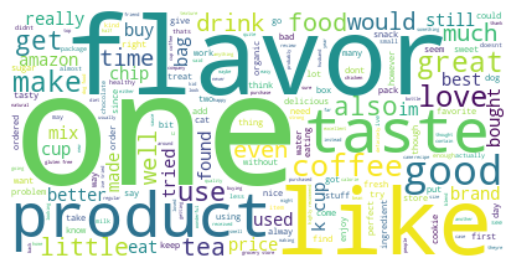

In [37]:
all_text = " ".join(review for review in df['CleanedText'])

wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud for positive review

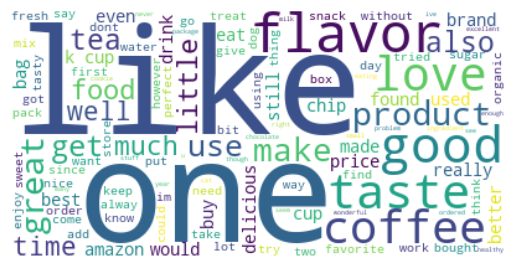

In [38]:
positive_text = " ".join(review for review in df['CleanedText'][df['Review']==1])

wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud for negative reviews

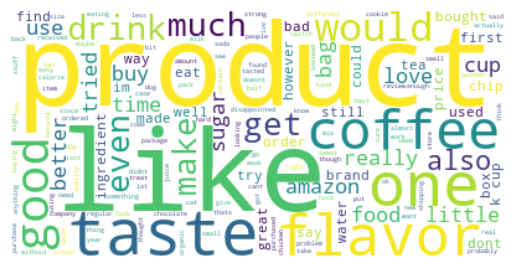

In [39]:
negative_text = " ".join(review for review in df['CleanedText'][df['Review']==0])

wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Finding most common words in NEGATIVE REVIEWS and then plotting the word cloud:

In [40]:
# Tokenize the sentences in the corpus and create a dictionary with sentences and their frequencies
wordfreq = {}
tokens = nltk.word_tokenize(negative_text)
for t in tokens:
    if t not in wordfreq.keys():
        wordfreq[t] = 1
    else:
        wordfreq[t] += 1
print(wordfreq)

{'product': 817, 'arrived': 77, 'labeled': 14, 'jumbo': 8, 'salted': 3, 'peanuts': 14, 'actually': 123, 'small': 132, 'sized': 12, 'unsalted': 3, 'sure': 164, 'error': 6, 'vendor': 14, 'intended': 8, 'represent': 2, 'looking': 147, 'secret': 4, 'ingredient': 82, 'robitussin': 1, 'believe': 83, 'found': 208, 'got': 206, 'addition': 21, 'root': 10, 'beer': 18, 'extract': 38, 'ordered': 180, 'good': 713, 'made': 257, 'cherry': 19, 'soda': 195, 'flavor': 689, 'medicinal': 7, 'cats': 84, 'happily': 5, 'eating': 111, 'felidae': 17, 'platinum': 3, 'two': 203, 'years': 82, 'new': 117, 'bag': 210, 'shape': 17, 'food': 402, 'different': 185, 'tried': 365, 'first': 322, 'put': 129, 'bowls': 8, 'sit': 12, 'full': 90, 'kitties': 2, 'touch': 15, 'ive': 245, 'noticed': 56, 'similar': 50, 'reviews': 149, 'related': 8, 'formula': 49, 'changes': 5, 'past': 48, 'unfortunately': 85, 'need': 106, 'find': 223, 'eat': 239, 'love': 288, 'watching': 5, 'tv': 2, 'movies': 2, 'sweet': 217, 'like': 1289, 'transfe

In [41]:
# Filter down to 200 most frequently ocurring words:
import heapq
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)
print(most_freq)

['like', 'coffee', 'taste', 'product', 'one', 'would', 'good', 'flavor', 'dont', 'really', 'much', 'even', 'get', 'buy', 'food', 'better', 'im', 'drink', 'sugar', 'tried', 'water', ':', '-', 'also', 'amazon', 'juice', 'little', 'time', 'tea', 'cup', 'first', 'try', 'use', '$', 'love', 'price', 'bad', 'box', 'great', 'make', '3', 'bought', 'orange', 'chips', 'well', 'made', 'didnt', 'know', 'still', 'think', 'ive', '2', 'thought', 'way', 'eat', 'something', '%', 'mix', 'chocolate', 'could', 'order', 'find', 'ingredients', 'tastes', 'want', 'however', 'sweet', 'used', 'say', 'bag', 'found', 'got', 'two', 'hot', 'soda', 'doesnt', 'brand', 'bit', 'flavors', 'different', 'since', 'disappointed', 'ordered', 'products', 'tasted', 'less', 'never', 'best', 'go', 'though', '1', '4', 'give', 'money', 'sure', 'many', 'cant', 'organic', 'going', ';', 'milk', '--', 'away', 'pack', 'may', 'back', 'store', 'size', 'green', 'switch', 'reviews', '5', 'said', 'looking', 'see', 'stuff', 'people', 'free', 

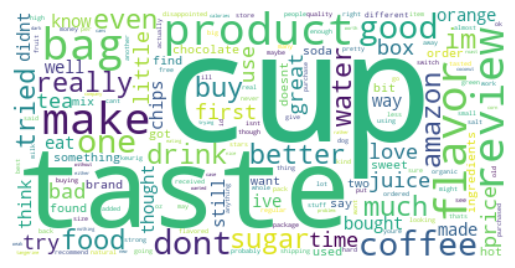

In [42]:
top_200_words = " ".join(word for word in most_freq)
wordcloud_top_200 = WordCloud(background_color="white").generate(top_200_words)
plt.imshow(wordcloud_top_200, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data Processing_2

Stemming

In [43]:
snow = nltk.stem.SnowballStemmer('english')
final_X = []
for text in df['CleanedText']:
  words = [snow.stem(word) for word in text.split()]
  final_X.append(words)
final_X[:10]

[['bought',
  'sever',
  'vital',
  'can',
  'dog',
  'food',
  'product',
  'found',
  'good',
  'qualiti',
  'product',
  'look',
  'like',
  'stew',
  'process',
  'meat',
  'smell',
  'better',
  'labrador',
  'finicki',
  'appreci',
  'product',
  'better'],
 ['product',
  'arriv',
  'label',
  'jumbo',
  'salt',
  'peanut',
  'peanut',
  'actual',
  'small',
  'size',
  'unsalt',
  'sure',
  'error',
  'vendor',
  'intend',
  'repres',
  'product',
  'jumbo'],
 ['confect',
  'around',
  'centuri',
  'light',
  'pillowi',
  'citrus',
  'gelatin',
  'nut',
  '-',
  'case',
  'filbert',
  'cut',
  'tini',
  'squar',
  'liber',
  'coat',
  'powder',
  'sugar',
  'tini',
  'mouth',
  'heaven',
  'chewi',
  'flavor',
  'high',
  'recommend',
  'yummi',
  'treat',
  'familiar',
  'stori',
  'c',
  'lewi',
  'lion',
  'witch',
  'wardrob',
  '-',
  'treat',
  'seduc',
  'edmund',
  'sell',
  'brother',
  'sister',
  'witch'],
 ['look',
  'secret',
  'ingredi',
  'robitussin',
  'believ',

In [44]:
final_y = df['Review']

# Convert to bag of words

In [45]:
stemmed_X = []
for row in final_X:
    sentence = ''
    for word in row:
        sentence = sentence + ' ' + word
    stemmed_X.append(sentence.strip())

In [46]:
stemmed_X[:5]

['bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better',
 'product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo',
 'confect around centuri light pillowi citrus gelatin nut - case filbert cut tini squar liber coat powder sugar tini mouth heaven chewi flavor high recommend yummi treat familiar stori c lewi lion witch wardrob - treat seduc edmund sell brother sister witch',
 'look secret ingredi robitussin believ found got addit root beer extract order good made cherri soda flavor medicin',
 'great taffi great price wide assort yummi taffi deliveri quick taffi lover deal']

In [47]:
count_vect = CountVectorizer(max_features=100)
bow_X = count_vect.fit_transform(stemmed_X)
final_X = bow_X
print(final_X[:5])

  (0, 7)	1
  (0, 22)	1
  (0, 32)	1
  (0, 68)	3
  (0, 33)	1
  (0, 38)	1
  (0, 50)	1
  (0, 48)	1
  (0, 5)	2
  (1, 68)	2
  (2, 81)	1
  (2, 31)	1
  (2, 41)	1
  (2, 71)	1
  (2, 88)	2
  (3, 33)	1
  (3, 38)	1
  (3, 50)	1
  (3, 31)	1
  (3, 44)	1
  (3, 39)	1
  (3, 62)	1
  (3, 53)	1
  (4, 40)	2
  (4, 67)	1


In [48]:
print("Count of final_X:")
print(final_X.shape[0])
print()
print("Count of final_y:")
print(final_y.value_counts())

Count of final_X:
9988

Count of final_y:
1    7612
0    2376
Name: Review, dtype: int64


# Plot the bag of words (before balancing)

In [49]:
pca = PCA(n_components = 2)

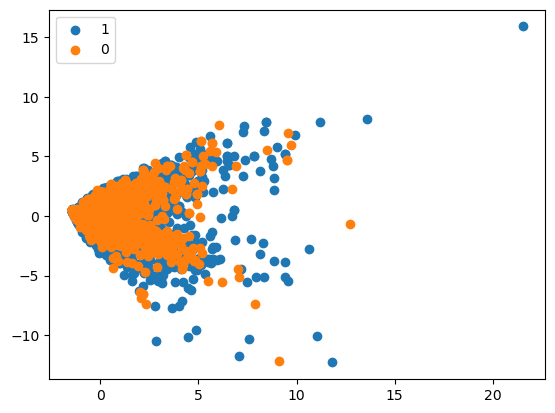

In [50]:
PCA_X = pca.fit_transform(final_X.toarray()) # Apply PCA to plot 2 dimensions

counter = Counter(final_y)
for label, _ in counter.items():
 row_ix = where(final_y == label)[0]
 plt.scatter(PCA_X[row_ix, 0], PCA_X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

# Applying SMOTE on dataset to balance it

In [51]:
oversample = SMOTE()

X_resampled, y_resampled = oversample.fit_resample(final_X, final_y)
X_resampled.shape

(15224, 100)

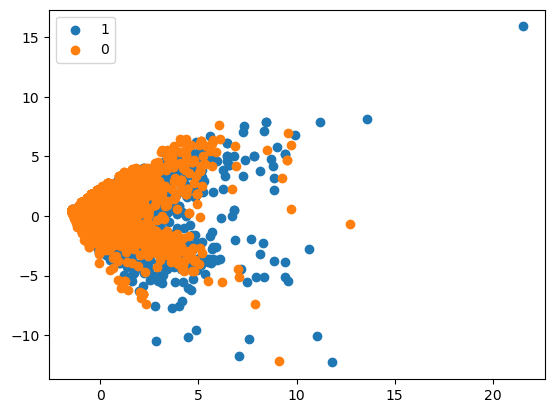

In [52]:
PCA_SMOTE_X = pca.transform(X_resampled.toarray())

for label, _ in counter.items():
 row_ix = where(y_resampled == label)[0]
 plt.scatter(PCA_SMOTE_X[row_ix, 0], PCA_SMOTE_X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [53]:
print("Shape of oversampled X:")
print(X_resampled.shape)
print()
print("Shape of oversampled y:")
print(y_resampled.shape)

Shape of oversampled X:
(15224, 100)

Shape of oversampled y:
(15224,)


In [54]:
df['StemmedText'] = stemmed_X
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount,HelpfulnessPercentage,HelpfulnessIndicator,CleanedText,StemmedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263,100.0,Useful,bought several vitality canned dog food produc...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190,0.0,Not Available,product arrived labeled jumbo salted peanuts p...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509,100.0,Useful,confection around centuries light pillowy citr...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219,100.0,Useful,looking secret ingredient robitussin believe f...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140,0.0,Not Available,great taffy great price wide assortment yummy ...,great taffi great price wide assort yummi taff...


# Logistic Regression

We have X-resampled, y_resampled -> Text input and Review (1/0 for positive/negative) for training input and output

In [55]:
# Training set and test set:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12179, 100)
(3045, 100)
(12179,)
(3045,)


In [56]:
lr = LogisticRegression(C=1e5)
result = lr.fit(X=X_train, y=y_train)
predictions = result.predict(X_test)

In [57]:
predictions[:5]

array([0, 0, 0, 1, 1], dtype=int64)

# F1 Score

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score
accuracy1 = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy1)
precision1 = precision_score(y_test, predictions)
print("Precision Score:", precision1)
recall1 = recall_score(y_test, predictions)
print("Recall Score:", recall1)
f1_score1 = f1_score(y_test, predictions)
print("F1 Score:", f1_score1)

Accuracy: 0.7924466338259442
Precision Score: 0.8351648351648352
Recall Score: 0.7369101486748546
F1 Score: 0.782967032967033


# Training_accuracy

In [59]:
training_predictions = result.predict(X_train)
training_accuracy1 = accuracy_score(y_train, training_predictions)
print(training_accuracy1)

0.8005583381229986


In [60]:
print(metrics.classification_report(y_test, predictions, target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.76      0.85      0.80      1498
    negative       0.84      0.74      0.78      1547

    accuracy                           0.79      3045
   macro avg       0.80      0.79      0.79      3045
weighted avg       0.80      0.79      0.79      3045



# Confusion_matrix

In [61]:
cm1 = confusion_matrix(y_test, predictions, labels=lr.classes_)
print(cm1)

[[1273  225]
 [ 407 1140]]


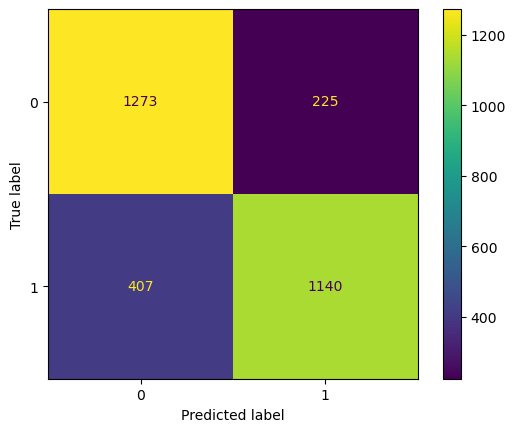

In [62]:
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=lr.classes_)
disp1.plot()
plt.show()

# Adding Features and then Applying Logistic Regression

In [63]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount,HelpfulnessPercentage,HelpfulnessIndicator,CleanedText,StemmedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263,100.0,Useful,bought several vitality canned dog food produc...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190,0.0,Not Available,product arrived labeled jumbo salted peanuts p...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509,100.0,Useful,confection around centuries light pillowy citr...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219,100.0,Useful,looking secret ingredient robitussin believe f...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140,0.0,Not Available,great taffy great price wide assortment yummy ...,great taffi great price wide assort yummi taff...


In [64]:
# Our output column
final_y.head() 

0    1
1    0
2    1
3    0
4    1
Name: Review, dtype: int64

In [65]:
multifeature_X = df[['WordCount',	'CharacterCount',	'HelpfulnessPercentage',	'HelpfulnessIndicator', 'StemmedText']]
multifeature_X.head()

,WordCount,CharacterCount,HelpfulnessPercentage,HelpfulnessIndicator,StemmedText
0,48,263,100.0,Useful,bought sever vital can dog food product found ...
1,31,190,0.0,Not Available,product arriv label jumbo salt peanut peanut a...
2,94,509,100.0,Useful,confect around centuri light pillowi citrus ge...
3,41,219,100.0,Useful,look secret ingredi robitussin believ found go...
4,27,140,0.0,Not Available,great taffi great price wide assort yummi taff...


In [66]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(multifeature_X, final_y, test_size=0.2, random_state=42)

In [67]:
X_train[:5]

,WordCount,CharacterCount,HelpfulnessPercentage,HelpfulnessIndicator,StemmedText
9529,17,78,100.000000,Useful,love green tea good price use tassimo machin
2169,75,373,0.000000,Not Available,heard wonder can food tri fussi schnauzer firs...
6270,66,361,0.000000,Not Available,tri duplic without buy prepackag stuff never c...
4781,107,581,82.352941,Useful,sinc began use sever year ago senior dog raeli...
8359,24,118,0.000000,Not Available,realli enjoy one ive tri mani top 5 littl pric...


In [68]:
# Convert output y to one hot encoding if it's categorical - in our case, we already have numerical values

# Converting Helpfulness Indicator
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train['HelpfulnessIndicator'].to_numpy().reshape(-1, 1))
X_test_encoded = encoder.transform(X_test['HelpfulnessIndicator'].to_numpy().reshape(-1, 1))

In [69]:
print(X_train_encoded[:5])
print(X_train_encoded.shape)

  (0, 3)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (3, 3)	1.0
  (4, 1)	1.0
(7990, 4)


# StandardScaler

In [70]:
# Scaling the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['WordCount',	'CharacterCount',	'HelpfulnessPercentage']])
X_test_scaled = scaler.transform(X_test[['WordCount',	'CharacterCount',	'HelpfulnessPercentage']])

In [71]:
print(X_train_scaled[:5])
print(X_train_scaled.shape)

[[-0.82982417 -0.84079984  1.31511415]
 [-0.01064847 -0.0999254  -0.85245898]
 [-0.13776194 -0.13006267 -0.85245898]
 [ 0.44131053  0.42245386  0.93260124]
 [-0.73095813 -0.74034229 -0.85245898]]
(7990, 3)


# CountVectorizer

In [72]:
vectorizer = CountVectorizer(max_features=100)
X_train_text = vectorizer.fit_transform(X_train['StemmedText'])
X_test_text = vectorizer.transform(X_test['StemmedText'])

In [73]:
print(X_train_text[:1])
print(X_train_text.shape)

  (0, 52)	1
  (0, 84)	1
  (0, 38)	1
  (0, 67)	1
  (0, 91)	1
(7990, 100)


# hstack

In [74]:
X_train_combined = hstack((X_train_encoded, X_train_scaled, X_train_text))
X_test_combined = hstack((X_test_encoded, X_test_scaled, X_test_text))

In [75]:
print(X_train_combined.shape)
print(X_test_combined.shape)

(7990, 107)
(1998, 107)


# 1. KNN

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train_combined, y_train)
KNeighborsClassifier(n_neighbors=3)
y_pred = knn_classifier.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7292292292292293

# 2. Naive Bayes classifier

In [77]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [78]:
# # GaussianNB
# G_classifier = GaussianNB()
# G_classifier.fit(X_train_combined, y_train)
# predictions_G = G_classifier.predict(X_test_combined)
# accuracy = metrics.accuracy_score(y_test_combined, predictions_G)
# accuracy

# # BernoulliNB
# B_classifier = BernoulliNB()
# B_classifier.fit(X_train_combined, y_train)
# predictions_B = B_classifier.predict(X_test_combined)
# accuracy_B = metrics.accuracy_score(y_test_combined, predictions_B)
# accuracy_B

# 3. Decision Tree

In [79]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train_combined, y_train)
DecisionTreeClassifier()
y_pred = clf.predict(X_test_combined)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.7432432432432432

# 4. Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100,
random_state=42)
rf_classifier.fit(X_train_combined, y_train)
RandomForestClassifier(random_state=42)
y_pred = rf_classifier.predict(X_test_combined)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.8253253253253253

# 5. Boosting Algorithm

In [81]:
from sklearn.ensemble import AdaBoostClassifier
base_classifier = DecisionTreeClassifier(max_depth=3)
adaboost_classifier = AdaBoostClassifier(base_classifier,
n_estimators=50, random_state=42)
adaboost_classifier.fit(X_train_combined, y_train)
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
random_state=42)
y_pred = adaboost_classifier.predict(X_test_combined)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.8028028028028028

# 6. SVM

In [82]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# # Instantiate StandardScaler
# scaler = StandardScaler()

# # Standardize the training and test data
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Instantiate SVM classifier with a linear kernel
# svm_classifier = SVC(kernel='linear', C=1.0)

# # Fit the SVM classifier on the standardized training data
# svm_classifier.fit(X_train_combined, y_train_combined)

# # Make predictions on the standardized test data
# y_pred = svm_classifier.predict(X_train_combined)

# # Calculate and print the accuracy
# accuracy = accuracy_score(y_test_combined, y_pred)
# print(f"Accuracy: {accuracy}")


In [83]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train_combined)
# X_test = scaler.transform(X_test_combined)
# svm_classifier = SVC(kernel='linear', C=1.0)
# svm_classifier.fit(X_train_combined, y_train)
# SVC(kernel='linear')
# y_pred = svm_classifier.predict(X_test_combined)
# accuracy = accuracy_score(y_test, y_pred)
# accuracy

In [84]:
# svm_classifier = SVC(kernel='linear', C=1.0)
# svm_classifier.fit(X_train_combined, y_train)
# SVC(kernel='linear')
# y_pred = svm_classifier.predict(X_test_combined)
# accuracy = accuracy_score(y_test, y_pred)
# accuracy

NameError: name 'SVC' is not defined

# 7. Logistic Regression

In [85]:
from sklearn import linear_model
lrg = linear_model.LogisticRegression()
lrg.fit(X_train_combined, y_train)
LogisticRegression()
lrg.score(X_test_combined, y_test)

0.8058058058058059

# Boosting Algorithm is the best accuracy

In [86]:
accuracy

0.8028028028028028

# Training Logistic Regression Model

In [87]:
combined_result = lr.fit(X=X_train_combined, y=y_train)
predictions_with_FE = combined_result.predict(X_test_combined)

In [88]:
accuracy2 = accuracy_score(y_test, predictions_with_FE)
print("Accuracy:", accuracy2)
precision2 = precision_score(y_test, predictions_with_FE)
print("Precision Score:", precision2)
recall2 = recall_score(y_test, predictions_with_FE)
print("Recall Score:", recall2)
f1_score2 = f1_score(y_test, predictions_with_FE)
print("F1 Score:", f1_score2)

Accuracy: 0.8073073073073073
Precision Score: 0.8161512027491409
Recall Score: 0.9570181329751511
F1 Score: 0.8809891808346213


In [89]:
training_predictions_with_FE = combined_result.predict(X_train_combined)
training_accuracy2 = accuracy_score(y_train, training_predictions_with_FE)
print(training_accuracy2)

0.8086357947434293


In [90]:
print(metrics.classification_report(y_test, predictions_with_FE, target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.75      0.37      0.49       509
    negative       0.82      0.96      0.88      1489

    accuracy                           0.81      1998
   macro avg       0.78      0.66      0.69      1998
weighted avg       0.80      0.81      0.78      1998



In [91]:
cm2 = confusion_matrix(y_test, predictions_with_FE, labels=lr.classes_)
print(cm2)

[[ 188  321]
 [  64 1425]]


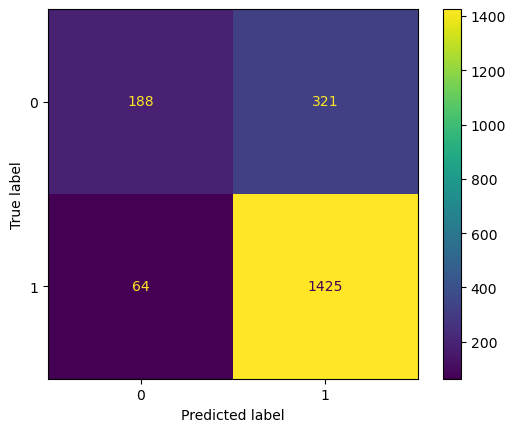

In [92]:
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=lr.classes_)
disp2.plot()
plt.show()

In [93]:
# Table:
comparison_table = PrettyTable(["Model", "Test Accuracy", "Train Accuracy", "Precision", "Recall", "F1 Score"])
comparison_table.add_row(["Logistic Regression with Text feature", round(accuracy1*100,2), round(training_accuracy1*100,2), round(precision1*100,2), round(recall1*100,2), round(f1_score1*100,2)])
comparison_table.add_row(["Logistic Regression with Feature Engineering", round(accuracy2*100,2), round(training_accuracy2*100,2), round(precision2*100,2), round(recall2*100,2), round(f1_score2*100,2)])
print(comparison_table)

+----------------------------------------------+---------------+----------------+-----------+--------+----------+
|                    Model                     | Test Accuracy | Train Accuracy | Precision | Recall | F1 Score |
+----------------------------------------------+---------------+----------------+-----------+--------+----------+
|    Logistic Regression with Text feature     |     79.24     |     80.06      |   83.52   | 73.69  |   78.3   |
| Logistic Regression with Feature Engineering |     80.73     |     80.86      |   81.62   |  95.7  |   88.1   |
+----------------------------------------------+---------------+----------------+-----------+--------+----------+


# Randomized Search Cross Validation

In [94]:
# Concatenate the test and train variables back to perform randomizedsearchcv and gridsearchcv
print(y_train.shape)
print(y_test.shape)
X_with_FE = vstack((X_train_combined, X_test_combined))
y_with_FE = np.concatenate((y_train, y_test))
print(y_with_FE.shape)

(7990,)
(1998,)
(9988,)


In [96]:
model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)


rscv_result = search.fit(X_with_FE, y_with_FE)

print('Best Score: %s' % rscv_result.best_score_)
# print('Best Hyperparameters: %s' % rscv_result.best_params_)

Best Score: 0.8029310539664581


In [97]:
print('Best Hyperparameters: %s' % rscv_result.best_params_)

Best Hyperparameters: {'C': 0.182591063301201, 'penalty': 'l2', 'solver': 'newton-cg'}


In [98]:
rscv_model = LogisticRegression(C=0.182591063301201, penalty='l2', solver='newton-cg')

rscv_model_result = rscv_model.fit(X=X_train_combined, y=y_train)
rscv_predictions_with_FE = combined_result.predict(X_test_combined)

accuracy_rscv = round(accuracy_score(y_test, rscv_predictions_with_FE)*100,2)
precision_rscv = round(precision_score(y_test, rscv_predictions_with_FE)*100,2)
recall_rscv = round(recall_score(y_test, rscv_predictions_with_FE)*100,2)
f1_score_rscv = round(f1_score(y_test, rscv_predictions_with_FE)*100,2)

# Training accuracy:
rscv_train_predictions = combined_result.predict(X_train_combined)
train_accuracy_rscv = round(accuracy_score(y_train, rscv_train_predictions)*100,2)

comparison_table.add_row(["Feature Engineering with RandomizedSearchCV", accuracy_rscv, train_accuracy_rscv, precision_rscv, recall_rscv, f1_score_rscv])
print(comparison_table)

+----------------------------------------------+---------------+----------------+-----------+--------+----------+
|                    Model                     | Test Accuracy | Train Accuracy | Precision | Recall | F1 Score |
+----------------------------------------------+---------------+----------------+-----------+--------+----------+
|    Logistic Regression with Text feature     |     79.24     |     80.06      |   83.52   | 73.69  |   78.3   |
| Logistic Regression with Feature Engineering |     80.73     |     80.86      |   81.62   |  95.7  |   88.1   |
| Feature Engineering with RandomizedSearchCV  |     80.73     |     80.86      |   81.62   |  95.7  |   88.1   |
+----------------------------------------------+---------------+----------------+-----------+--------+----------+


# Grid Search Cross Validation

In [99]:
model = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

gscv_result = search.fit(X_with_FE, y_with_FE)

print('Best Score: %s' % gscv_result.best_score_)
# print('Best Hyperparameters: %s' % gscv_result.best_params_)

Best Score: 0.8024305868995248


In [100]:
print('Best Hyperparameters: %s' % gscv_result.best_params_)

Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [101]:
gscv_model = LogisticRegression(C=1, penalty='l1', solver='liblinear')

gscv_model_result = gscv_model.fit(X=X_train_combined, y=y_train)
gscv_predictions_with_FE = combined_result.predict(X_test_combined)

accuracy_gscv = round(accuracy_score(y_test, gscv_predictions_with_FE)*100,2)
precision_gscv = round(precision_score(y_test, gscv_predictions_with_FE)*100,2)
recall_gscv = round(recall_score(y_test, gscv_predictions_with_FE)*100,2)
f1_score_gscv = round(f1_score(y_test, gscv_predictions_with_FE)*100,2)

# Training accuracy:
gscv_train_predictions = combined_result.predict(X_train_combined)
train_accuracy_gscv = round(accuracy_score(y_train, gscv_train_predictions)*100,2)

comparison_table.add_row(["Feature Engineering with GridSearchCV", accuracy_gscv, train_accuracy_gscv, precision_gscv, recall_gscv, f1_score_gscv])
print(comparison_table)

+----------------------------------------------+---------------+----------------+-----------+--------+----------+
|                    Model                     | Test Accuracy | Train Accuracy | Precision | Recall | F1 Score |
+----------------------------------------------+---------------+----------------+-----------+--------+----------+
|    Logistic Regression with Text feature     |     79.24     |     80.06      |   83.52   | 73.69  |   78.3   |
| Logistic Regression with Feature Engineering |     80.73     |     80.86      |   81.62   |  95.7  |   88.1   |
| Feature Engineering with RandomizedSearchCV  |     80.73     |     80.86      |   81.62   |  95.7  |   88.1   |
|    Feature Engineering with GridSearchCV     |     80.73     |     80.86      |   81.62   |  95.7  |   88.1   |
+----------------------------------------------+---------------+----------------+-----------+--------+----------+
